In [1]:
%reload_ext autoreload
%autoreload 2

In [226]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# custom
from bleachbench.utils import config, utils
from bleachbench.plotting import spatial
from bleachbench.data import processing

donner_fp = config.bleaching_dir / "donner/BleachingdatabaseV1.0.xlsx"
raw_donner_df = pd.read_excel(donner_fp, dtype={"DEPTH": object})

### Processing – Donner
From https://doi.org/10.1371/journal.pone.0175490 (2017) downloadable [here](https://figshare.com/projects/Coral_Bleaching_Database_V1/19753)
1. Ranges reported in `percent_bleached` turned averaged
2. Many nans in `month`. Using year only for date. This is problematic for finding the preceeding timeseries!
3. Depth column is a mess (ranges, dates, '+'...)

In [229]:
# processing
donner_df = processing.process_bleaching_dataframe(raw_donner_df)

print(donner_df.columns)
donner_df.describe()

Index(['country', 'location', 'site_name', 'latitude', 'longitude', 'month',
       'year', 'depth', 'severity_code', 'percent_bleached', 'mortality_code',
       'percent_mortality', 'survey_type', 'source', 'name', 'citation',
       'comments', 'entry_code', 'database_code', 'date',
       'min_percent_bleached', 'max_percent_bleached', 'mean_percent_bleached',
       'min_percent_mortality', 'max_percent_mortality',
       'mean_percent_mortality'],
      dtype='object')


,latitude,longitude,month,year,severity_code,mortality_code,database_code,date,min_percent_bleached,max_percent_bleached,mean_percent_bleached,min_percent_mortality,max_percent_mortality,mean_percent_mortality
count,7437.000000,7437.000000,6792.000000,7437.000000,7437.000000,617.000000,7437.000000,7437,4439.000000,4439.000000,4439.000000,2830.000000,2830.000000,2830.00000
mean,8.336823,-12.606580,6.640901,2002.268926,1.672852,1.719611,1.441307,2002-04-09 06:29:11.351351296,32.531389,33.100413,32.815901,2.325319,2.361361,2.34334
min,-33.600000,-179.966700,1.000000,1963.000000,-1.000000,-1.000000,1.000000,1963-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,-6.350000,-87.460800,4.000000,1998.000000,1.000000,1.000000,1.000000,1998-01-01 00:00:00,7.700000,8.000000,7.700000,0.000000,0.000000,0.00000
50%,17.759000,-74.557500,6.000000,2005.000000,2.000000,2.000000,1.000000,2005-01-01 00:00:00,25.000000,26.086957,25.400000,0.000000,0.000000,0.00000
75%,19.932050,101.906700,9.000000,2005.000000,3.000000,3.000000,2.000000,2005-01-01 00:00:00,50.000000,51.800000,51.464124,0.000000,0.000000,0.00000
max,43.000000,199.980000,12.000000,2011.000000,3.000000,11.000000,2.000000,2011-01-01 00:00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
std,16.488155,101.461666,2.979811,4.890602,1.194564,1.251293,0.496577,NaN,28.498146,28.782067,28.570118,10.506307,10.693553,10.58783


(0.0, 100.0)

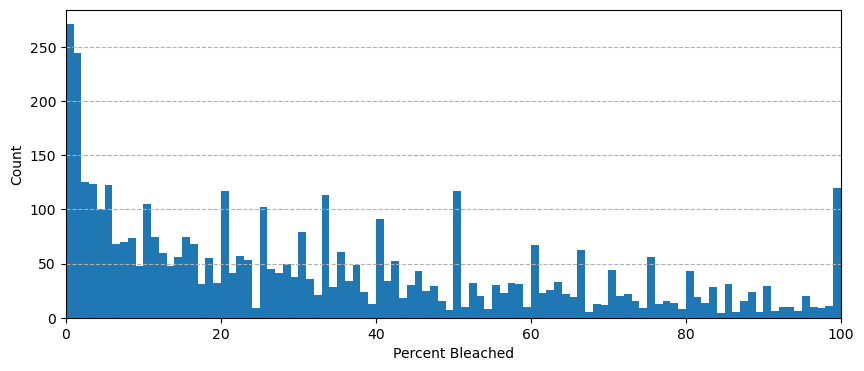

In [230]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(donner_df["mean_percent_bleached"], bins=100)
ax.set_xlabel("Percent Bleached")
ax.set_ylabel("Count")
ax.grid(axis="y", linestyle="--")
ax.set_xlim(0, 100)

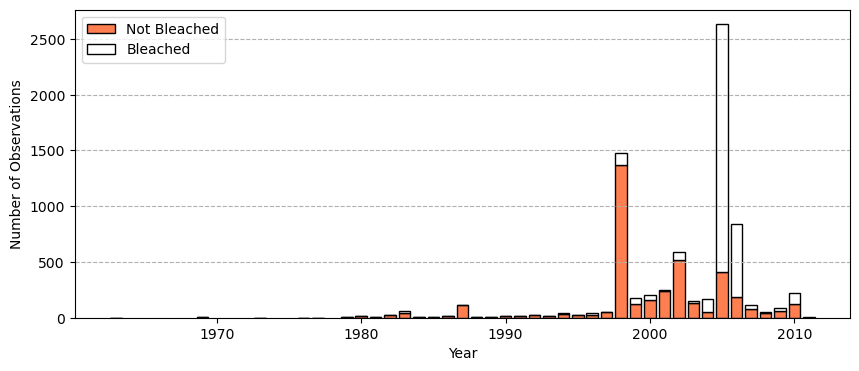

In [231]:
bleach_threshold = 5
donner_df["bleach_presence"] = donner_df["mean_percent_bleached"].apply(
    lambda x: "bleached" if x > bleach_threshold else "not bleached"
)
# plot stacked bar chart of number of observations against time, colored by bleaching presence
fig, ax = plt.subplots(figsize=(10, 4))

# Extract year and bleaching presence
donner_df["year"] = donner_df["date"].dt.year

# Count number of observations per year and bleaching presence
obs_by_year_bleach = (
    donner_df.groupby(["year", "bleach_presence"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Ensure both categories exist for all years
for cat in ["bleached", "not bleached"]:
    if cat not in obs_by_year_bleach.columns:
        obs_by_year_bleach[cat] = 0
obs_by_year_bleach = obs_by_year_bleach[["bleached", "not bleached"]]

ax.bar(
    obs_by_year_bleach.index,
    obs_by_year_bleach["not bleached"],
    color="coral",
    label="Not Bleached",
    edgecolor="black",
)
ax.bar(
    obs_by_year_bleach.index,
    obs_by_year_bleach["bleached"],
    bottom=obs_by_year_bleach["not bleached"],
    color="white",
    edgecolor="black",
    label="Bleached",
)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Observations")
ax.grid(axis="y", linestyle="--")
ax.legend()


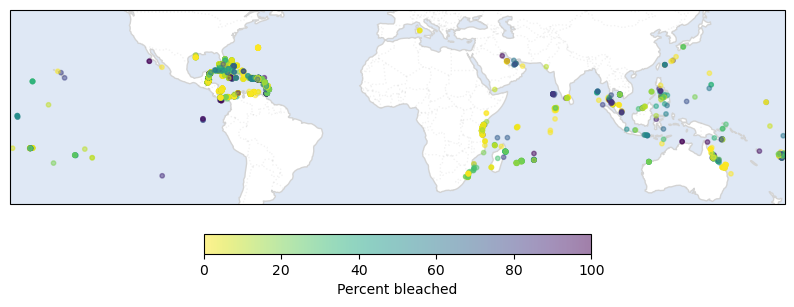

In [232]:
# plot spatial distribution of bleaching
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
spatial.format_geo_axes(ax)


# plot lat lon scatter using matplotlib directly to avoid pandas' colorbar issues with GeoAxes
scatter = ax.scatter(
    donner_df["longitude"],
    donner_df["latitude"],
    c=donner_df["mean_percent_bleached"],
    cmap="viridis_r",
    s=10,
    transform=ccrs.PlateCarree(),
    alpha=0.5,
)
# add colorbar
cbar = plt.colorbar(
    scatter,
    ax=ax,
    orientation="horizontal",
    pad=0.05,
    shrink=0.5,
    label="Percent bleached",
)


### Processing – Global Coral Bleaching Database

Database [here](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0228498) via [gov.noaa.nodc:0228498](gov.noaa.nodc:0228498)
1. Day column involves some ranges. Leaving for now to be consistent with Donner

In [233]:
raw_noaa_df = pd.read_csv(
    config.bleaching_dir / "noaa/Global_Coral_Bleaching_Database.csv"
)
noaa_df = processing.process_bleaching_dataframe(raw_noaa_df)

noaa_df.columns
noaa_df.describe()

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_57156/4135640026.py:1: DtypeWarning: Columns (6,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_noaa_df = pd.read_csv(


,latitude,longitude,month,year,min_percent_bleached,max_percent_bleached,date,mean_percent_bleached,min_percent_mortality,max_percent_mortality,mean_percent_mortality
count,33244.000000,33244.000000,32660.000000,33244.000000,29088.000000,29088.000000,33244,29088.000000,9910.000000,9910.000000,9910.000000
mean,7.008585,19.966966,6.723546,2010.732734,14.649715,16.716702,2010-09-25 12:00:02.598964992,15.683209,6.376298,7.720022,7.048160
min,-31.540000,-179.966700,1.000000,1963.000000,0.000000,0.000000,1963-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,-11.363627,-80.728382,4.000000,2006.000000,0.000000,0.000000,2006-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000
50%,11.791894,40.352720,7.000000,2014.000000,1.222745,2.500000,2014-01-01 00:00:00,2.500000,0.000000,0.000000,0.000000
75%,21.593900,125.132455,9.000000,2016.000000,19.100281,23.529000,2016-01-01 00:00:00,20.500000,1.087500,2.077500,2.067500
max,32.510000,179.945000,12.000000,2021.000000,100.000000,100.000000,2021-01-01 00:00:00,100.000000,100.000000,100.000000,100.000000
std,17.046755,109.944110,2.907248,6.215800,24.097315,26.094975,NaN,24.854329,18.242016,20.532221,19.135624


# Study processing
As in [Lachs et al. (2021)](https://doi.org/10.3390/rs13142677), from pages 3-4:
> 1. Data were first filtered for errors. This excluded observations that did not have a recorded month or year, as well as observations in which the coordinates provided did not correspond with a coral reef location (5562 observations excluded).

This removes many more than 5562. They probably did it manually
>
> 2. Data were removed if the survey date fell outside the period of peak thermal exposure for that year. As, for the purpose of this study, we are only interested in coral bleaching that results from thermal stress (i.e., not bleaching due to cold stress, nutrient enrichment, etc.), instances of bleaching that cannot be linked to the period of peak thermal exposure may not accurately reflect the status of heat-induced bleaching for that year and location. We defined the period of peak thermal exposure as the month prior to the month of MMM up to three months after the month of MMM. For example, if the month of MMM was February for a certain location, only observations from January to May were included. Further, we ensured that the observation was not made before the date of maximum DHW in that year (19,292 observations excluded). 
>
> 3. To account for different sampling protocols in records of percentage bleaching, we computed bleaching as a binary variable. Bleaching estimates were reported as means, ranges or broad categories. First, we summarised these as representative minimum and maximum percentages. Then, the absence of ecologically significant bleaching was defined as having a maximum estimation of 10% bleaching or less, while the presence of ecologically significant bleaching was defined as having a minimum estimation of 20% bleaching or greater. Observations in which the maximum estimation exceeded 10% while the minimum estimation remained below 20% were filtered out to reduce the chance of misrepresenting bleaching and non-bleaching observations (Figure S1) (1452 observations excluded).
>
> 4. Lastly, to account for spatiotemporal patchiness a priori, we only retained years which had greater than 100 independent observations, had a qualitatively even global distribution and were not temporally isolated (i.e., all proceeding years also needed to meet the previous two criteria). This resulted in removal of all data before 2003. Despite having 345 bleaching records in 2002, all data from this year were removed as over 80% of records were from the Great Barrier Reef region alone (1185 observations excluded). 
>
> The resulting dataset included 10,380 unique observations between 2003 and 2017, with >171 observations per year and sufficient spatial representation for each year


In [234]:
noaa_df["source"] = "noaa"
donner_df["source"] = "donner"
combined_df = pd.concat([noaa_df, donner_df], axis=0)

# 1.1 remove rows with nan month and/or year
combined_df = combined_df[combined_df["month"].notna() & combined_df["year"].notna()]
print(
    f"Dropped {len(noaa_df) + len(donner_df) - len(combined_df)} rows due to missing month and/or year"
)

Dropped 1229 rows due to missing month and/or year


(1977.0, 2021.0)

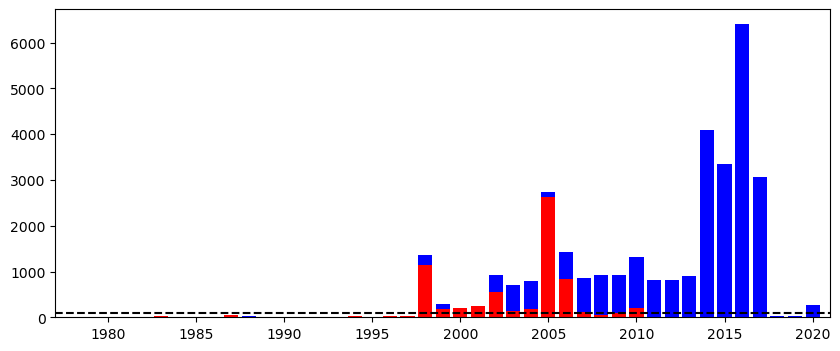

In [287]:
# plot stacked bar chart of number of observations against time, colored by source
fig, ax = plt.subplots(figsize=(10, 4))

combined_df["year"] = combined_df["date"].dt.year

# Count number of observations per year and source
obs_by_year_source = (
    combined_df.groupby(["year", "source"]).size().unstack(fill_value=0).sort_index()
)
min_year, max_year = obs_by_year_source.index.min(), obs_by_year_source.index.max()
ax.bar(
    obs_by_year_source.index,
    obs_by_year_source["noaa"],
    color="blue",
    label="NOAA",
)

ax.bar(
    obs_by_year_source.index,
    obs_by_year_source["donner"],
    color="red",
    label="Donner",
)
ax.hlines(100, min_year, max_year, colors="black", linestyles="--")
ax.set_xlim(min_year, max_year)

In [249]:
# # 1.2 remove rows where latitude and longitude are not on reef sites
import geopandas as gpd

print("Loading UNEP-GCDR dataframe...")
unep_gdcr_fp = config.unep_gdcr_dir / "WCMC008_CoralReef2021_Py_v4_1.shp"
unep_gdcr_df = gpd.read_file(unep_gdcr_fp)

gdf_points = gpd.GeoDataFrame(
    combined_df,
    geometry=gpd.points_from_xy(combined_df.longitude, combined_df.latitude),
    crs="EPSG:4326",  # adjust CRS if needed
)
unep_gdcr_df = unep_gdcr_df.to_crs(gdf_points.crs)

print("Joining dataframes...")
reef_points = gpd.sjoin(
    gdf_points,
    unep_gdcr_df[["geometry"]],
    how="inner",
)

Loading UNEP-GCDR dataframe...
Joining dataframes...


Removed 16074 points
Before: 39452 After: 20023


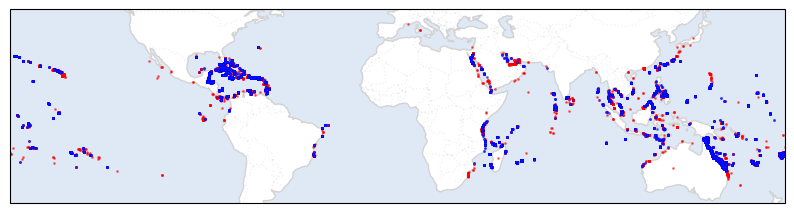

In [250]:
# plot comparison: removed points in red, reef points in blue
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
spatial.format_geo_axes(ax)

# get points that are not in reef_points
removed_points_df = gdf_points[~gdf_points.index.isin(reef_points.index)]
scatter_removed = ax.scatter(
    removed_points_df["longitude"],
    removed_points_df["latitude"],
    s=1,
    facecolor="red",
    edgecolor=None,
    transform=ccrs.PlateCarree(),
    alpha=0.5,
)
scatter_reef = ax.scatter(
    reef_points["longitude"],
    reef_points["latitude"],
    s=1,
    facecolor=None,
    edgecolor="blue",
    transform=ccrs.PlateCarree(),
    alpha=0.5,
)
print(
    f"Removed {len(removed_points_df)} points\nBefore: {len(gdf_points)} After: {len(reef_points)}"
)

In [ ]:
# 2.1 Remove points falling outside of maximum exposure period

In [303]:
from pathlib import Path

lats = (-30, -20)
lons = (140, 150)


def name_output_dir(dirname: str) -> Path:
    """Name the output directory based on the spatial extent"""
    print(dirname / f"{min(lats):.0f}_{max(lats):.0f}_{min(lons):.0f}_{max(lons):.0f}")


name_output_dir(config.crw_sst_dir)

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/bleachbench/data/sst/CRW_SST/-30_-20_140_150


In [253]:
# 3.0 remove points without percentage bleached
reef_points = reef_points[reef_points["mean_percent_bleached"].notna()]
# 3.1 Mark absence of ecologically significant bleaching as maximum observation <=10%
reef_points["bleach_presence"] = reef_points["max_percent_bleached"].apply(
    lambda x: 0 if x <= 10 else 1
)
# 3.2 Mark presence of ecologically significant bleaching for minimum observation >=20%
reef_points["bleach_presence"] = reef_points["min_percent_bleached"].apply(
    lambda x: 1 if x >= 20 else 0
)
# 3.3 Remove observations which have max estimation > 10% while minimum < 20%
reef_points["bleach_presence"] = (
    (reef_points["max_percent_bleached"] <= 10)
    | (reef_points["min_percent_bleached"] >= 20)
).astype(int)
print(
    f"Number of non-bleached observations: {reef_points[reef_points['bleach_presence'] == 0].shape[0]}"
)

Number of non-bleached observations: 1750


In [ ]:
# 4.0 Drop years after 2017, since dataset poorly populated
reef_points = reef_points[reef_points["year"] <= 2017]
no_obs_per_year = reef_points.groupby("year").size()

# 4.1 Retain only years with >100 independent observations, and for which all proceeding years also have >100 independent observations
valid_years = []
years_sorted = sorted(no_obs_per_year.index)

obs_threshold = 100
valid = True
for year in reversed(years_sorted):
    if no_obs_per_year.loc[year] >= obs_threshold and valid:
        valid_years.append(year)  # update earliest valid year
    else:
        valid = False  # once we hit a failing year, stop
        break

reef_points = reef_points[reef_points["year"].isin(valid_years)]

In [ ]:
import xarray as xa

xa.open_dataset(
    "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/bleachbench/data/sst/CRW_SST/-5_5_0_10/CRW_SST_2003-02-01_2003-02-28.nc"
)

<xarray.Dataset> Size: 9MB
Dimensions:    (time: 28, latitude: 201, longitude: 201)
Coordinates:
  * time       (time) datetime64[ns] 224B 2003-02-01T12:00:00 ... 2003-02-28T...
  * latitude   (latitude) float32 804B 5.025 4.975 4.925 ... -4.925 -4.975
  * longitude  (longitude) float32 804B 0.025 0.075 0.125 ... 9.925 9.975 10.02
Data variables:
    CRW_SST    (time, latitude, longitude) float64 9MB ...
Attributes: (12/63)
    acknowledgement:            NOAA Coral Reef Watch (CRW)
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    Conventions:                CF-1.6, ACDD-1.3
    creator_email:              coralreefwatch@noaa.gov
    creator_institution:        NOAA Coral Reef Watch (CRW)
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          2003-02-28T12:00:00Z
    time_coverage_resolution:   P1D
    time_coverage_start:        2003-02-01T12:00:00Z
    title:                      NOAA Coral Reef Watch Operational Daily Near-...
    Westernmost_Easting:        0.025

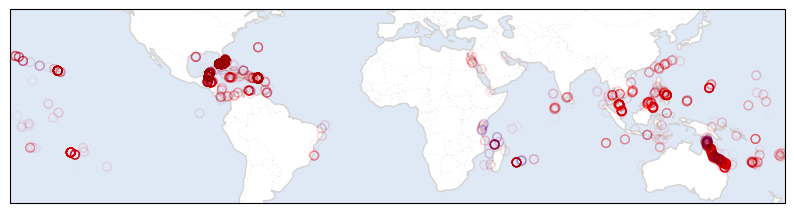

In [301]:
# plot spatial distribution of bleaching
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
spatial.format_geo_axes(ax)

# Map bleach_presence to colors: 1 -> 'red', 0 -> 'blue'
edge_colors = reef_points["bleach_presence"].map({1: "red", 0: "blue"}).values

# plot lat lon scatter using matplotlib directly to avoid pandas' colorbar issues with GeoAxes
scatter = ax.scatter(
    reef_points["longitude"],
    reef_points["latitude"],
    s=40,
    facecolors="none",
    edgecolors=edge_colors,
    transform=ccrs.PlateCarree(),
    alpha=0.01,
)